In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima, ndiffs, nsdiffs

from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../attributes_dataset/rainfall_clean.csv')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.head()

,rainfall
date,
2020-01-01,0.2
2020-01-02,0.0
2020-01-03,0.5
2020-01-04,7.6
2020-01-05,4.3


# Splitting Data

In [4]:
train_ratio = int(len(df) * 0.9)

In [5]:
dtrain = df.iloc[:train_ratio]
dtest = df.iloc[train_ratio:]

In [6]:
print(dtrain.shape)
print(dtest.shape)

(738, 1)
(83, 1)


# Visualisasi ACF dan PACF

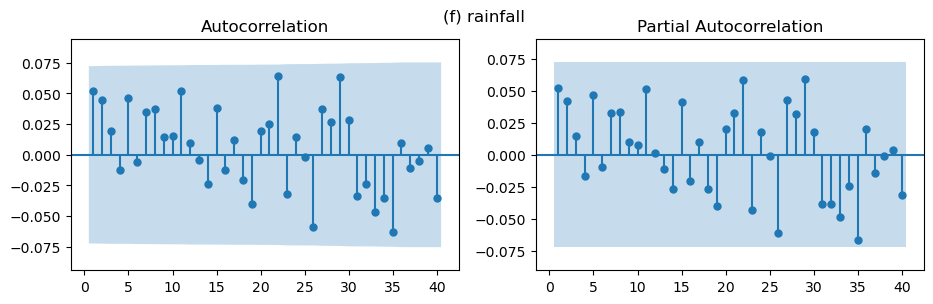

In [7]:
lags = 40
fig, ax = plt.subplots(1,2,figsize=(11,3))
plt.suptitle('(f) rainfall', fontsize=12)
sgt.plot_acf(dtrain, lags=lags, zero=False, ax=ax[0], auto_ylims=True)
sgt.plot_pacf(dtrain, lags=lags, zero=False, ax=ax[1], auto_ylims=True)
plt.show()

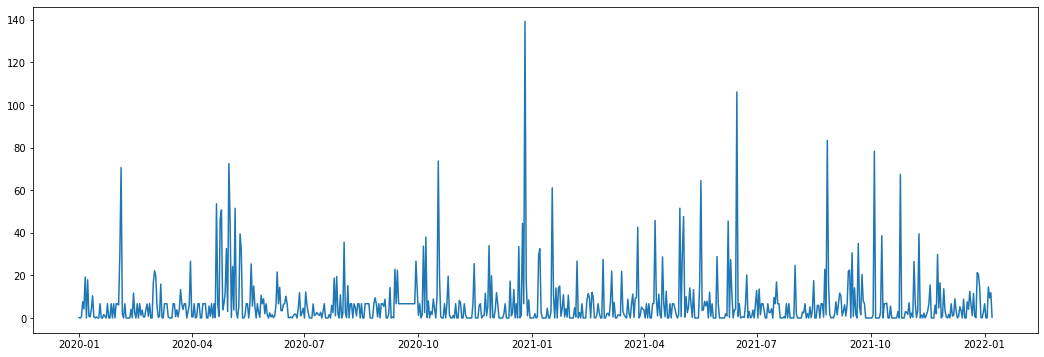

In [8]:
plt.figure(figsize=(18,6))
plt.plot(dtrain)

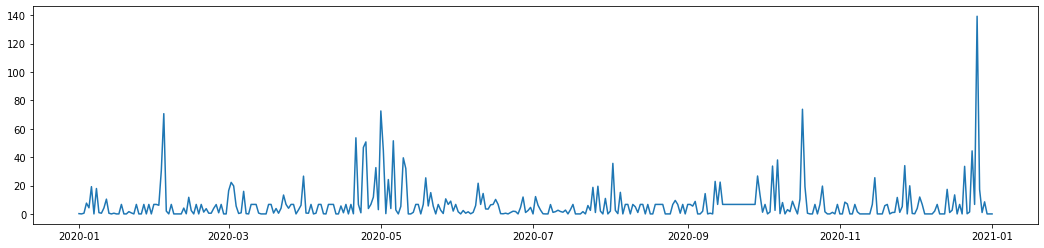

In [9]:
plt.figure(figsize=(18,4))
plt.plot(dtrain.loc['2020-01-01':'2021-01-01'])

In [10]:
dtrain.head(5)

,rainfall
date,
2020-01-01,0.2
2020-01-02,0.0
2020-01-03,0.5
2020-01-04,7.6
2020-01-05,4.3


[]

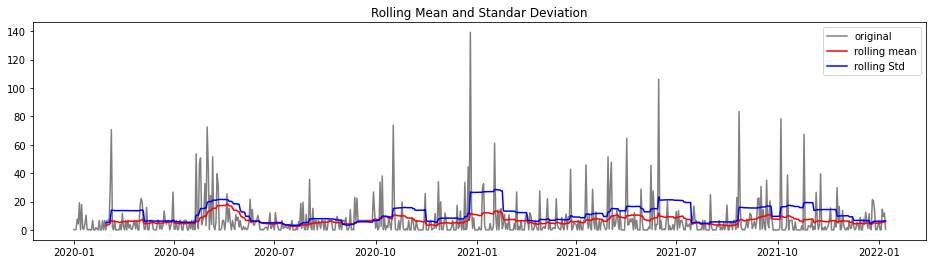

In [11]:
rolling_mean = dtrain.rolling(window=30).mean()
rolling_std =dtrain.rolling(window=30).std()

plt.figure(figsize=(16,4))
plt.plot(dtrain, color='grey', label='original')
plt.plot(rolling_mean, color='red', label='rolling mean')
plt.plot(rolling_std, color='blue', label='rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standar Deviation')
plt.plot()

# Stasionary Test (dickey fuller)

In [23]:
adf = sts.adfuller(dtrain)
print(f'ADF p values\t\t: {adf[1]}')
print(f'ADF statistic values\t: {adf[0]}')
print(f'ADF critical values\t: {adf[4]}')

ADF p values		: 0.0
ADF statistic values	: -25.739189564508255
ADF critical values	: {'1%': -3.4392539652094154, '5%': -2.86546960465041, '10%': -2.5688625527782327}


In [28]:
# p-value < 0.05 tidak stasioner
sts.kpss(dtrain, regression='ct')

(0.03689842726751657,
 0.1,
 20,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [24]:
d_value = ndiffs(dtrain, test='kpss')
d_value

0

# Levene Test

In [25]:
len_dtrain = len(dtrain)
levgrp_1 = dtrain.rainfall.iloc[int(0.2*len_dtrain):int(0.6*len_dtrain)].values
levgrp_2 = dtrain.rainfall.iloc[:int(0.4*len_dtrain)].values
levgrp_3 = dtrain.rainfall.iloc[int(0.5*len_dtrain):].values
levgrp_4 = dtrain.rainfall.iloc[int(0.2*len_dtrain):].values

In [27]:
#levene p-value > 0.05 == varian stasioner

levene_val = stats.levene(levgrp_1, levgrp_2, levgrp_3, levgrp_4, center='mean')
print(levene_val)
if levene_val[1] > 0.05:
    print('Varian Stasioner')
else:
    print('Varian Tidak Stasioner')    

LeveneResult(statistic=0.8310257193070975, pvalue=0.4767613376679628)
Varian Stasioner


### Data tidak bisa di lakukan transformasi boxcox

# Auto Arima Model

In [14]:
train_exg = pd.read_csv('../R_resource/rainfall_train_exog182.csv')
train_exg = train_exg.drop(columns='Unnamed: 0')

In [15]:
test_exg = pd.read_csv('../R_resource/rainfall_test_exog182.csv')
test_exg = test_exg.drop(columns='Unnamed: 0')

In [16]:
print(train_exg.shape)
print(test_exg.shape)

(738, 364)
(83, 364)


In [17]:
%%time
model = auto_arima(dtrain, exogenous=train_exg, trace=True, stepwise=True,
                       max_p=7, max_q=7, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6062.365, Time=40.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6055.965, Time=5.67 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6056.933, Time=8.83 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6056.989, Time=10.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6385.352, Time=12.96 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6058.553, Time=41.74 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 119.830 seconds
Wall time: 1min 59s


In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  738
Model:                        SARIMAX   Log Likelihood               -2661.982
Date:                Wed, 29 Jun 2022   AIC                           6055.965
Time:                        16:11:33   BIC                           7741.008
Sample:                             0   HQIC                          6705.737
                                - 738                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7258   3138.826      0.002      0.998   -6145.260    6158.711
S1-365         0.5795   4678.488      0.000      1.000   -9169.089    9170.248
C1-365        -0.2925   4150.281  -7.05e-05      1.000   -8134.695    8134.110
S2-365        -1.4573   4936.160     -0.000      1.000   -9676.153    9673.238
C2-365        -0.9744   3840.613     -0.000      1.000   -7528.437    7526.488
S3-365         1.1654   4604.619      0.000      1.000   -9023.723    9026.054
C3-365         2.1274   4232.610      0.001      1.000   -8293.636    8297.891
S4-365         0.5047   4419.853      0.000      1.000   -8662.248    8663.257
C4-365         0.2936   4428.533   6.63e-05      1.000   -8679.472    8680.059
S5-365        -0.9739   4580.348     -0.000      1.000   -8978.291    8976.343
C5-365        -0.0264   4260.249  -6.19e-06      1.000   -8349.962    8349.909
S6-365        -0.4509   4562.822  -9.88e-05      1.000   -8943.418    8942.516
C6-365         1.0373   4277.280      0.000      1.000   -8382.277    8384.352
S7-365         0.8322   4570.789      0.000      1.000   -8957.749    8959.413
C7-365        -0.0938   4269.149   -2.2e-05      1.000   -8367.472    8367.284
S8-365        -1.1587   3962.835     -0.000      1.000   -7768.173    7765.856
C8-365        -0.0614   4838.195  -1.27e-05      1.000   -9482.750    9482.627
S9-365        -0.0644   4808.139  -1.34e-05      1.000   -9423.845    9423.716
C9-365         1.7659   3999.527      0.000      1.000   -7837.164    7840.696
S10-365       -0.3657   4190.308  -8.73e-05      1.000   -8213.218    8212.486
C10-365       -0.0702   4642.686  -1.51e-05      1.000   -9099.567    9099.426
S11-365       -1.1341   4173.197     -0.000      1.000   -8180.450    8178.181
C11-365        0.8417   4658.319      0.000      1.000   -9129.297    9130.980
S12-365       -0.5985   4274.925     -0.000      1.000   -8379.298    8378.101
C12-365        0.9005   4565.582      0.000      1.000   -8947.476    8949.277
S13-365       -0.1548   4626.895  -3.35e-05      1.000   -9068.702    9068.393
C13-365        0.2951   4208.992   7.01e-05      1.000   -8249.178    8249.768
S14-365       -0.0983   4434.545  -2.22e-05      1.000   -8691.648    8691.451
C14-365       -0.1727   4409.972  -3.92e-05      1.000   -8643.558    8643.213
S15-365       -1.7413   4029.408     -0.000      1.000   -7899.236    7895.754
C15-365        0.0096   4783.359      2e-06      1.000   -9375.202    9375.221
S16-365        0.2083   4908.137   4.24e-05      1.000   -9619.564    9619.981
C16-365       -0.6948   3878.025     -0.000      1.000   -7601.484    7600.095
S17-365       -1.2075   4836.692     -0.000      1.000   -9480.950    9478.535
C17-365       -0.0265   3965.337  -6.69e-06      1.000   -7771.943    7771.890
S18-365       -0.5739   3908.253     -0.000      1.000   -7660.608    7659.460
C18-365        0.7867   4883.311      0.000      1.000   -9570.327    9571.900
S19-365        0.1357   3517.481   3.86e-05      1.000   -6894.001    6894.272
C1

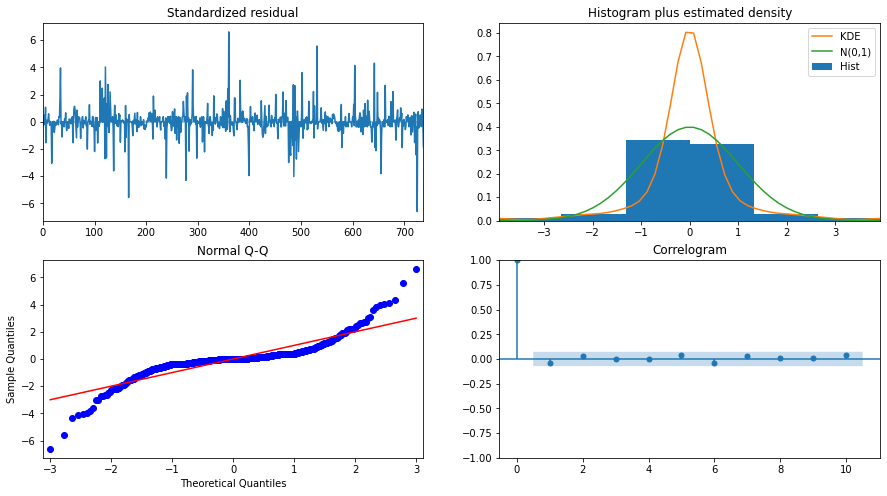

In [19]:
model.plot_diagnostics(figsize=(15,8));

In [21]:
predictions = model.predict(n_periods = len(dtest), exogenous=test_exg)

In [22]:
results = pd.DataFrame(data={'date': dtest.index, 'Predictions': predictions, 'Actuals': dtest.rainfall.values})
results.set_index('date', inplace=True)

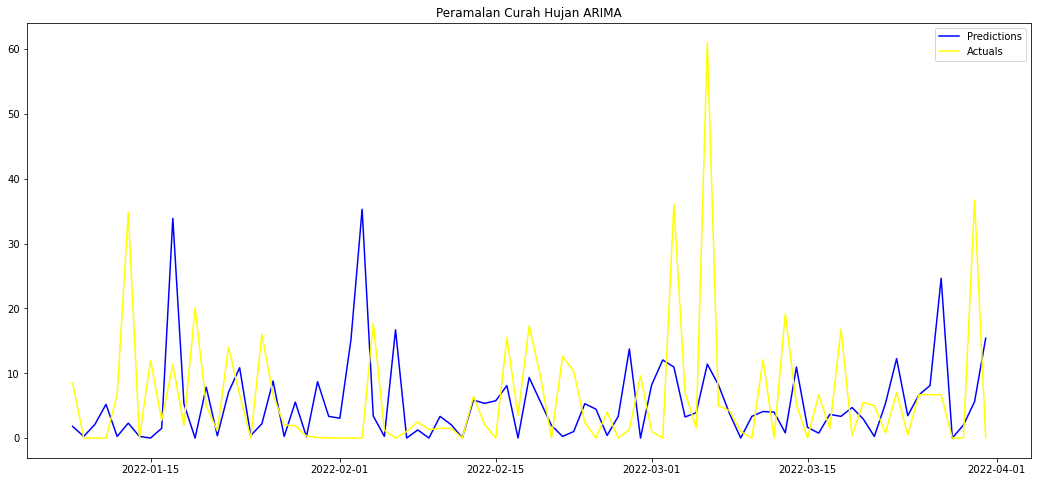

In [23]:
plt.figure(figsize=(18,8))
plt.title('Peramalan Curah Hujan ARIMA')
plt.plot(results.Predictions, label='Predictions', color='blue')
plt.plot(results.Actuals, label='Actuals', color='yellow')
plt.legend()

# Calculating Errors

In [24]:
test_MAE = mean_absolute_error(results.Actuals, results.Predictions)
test_RMSE = sqrt(mean_squared_error(results.Actuals, results.Predictions))
print(f'Mean Absolute Error is\t\t: {test_MAE}')
print(f'Root Mean Squared Error is\t: {test_RMSE}')

Mean Absolute Error is		: 7.283672816497019
Root Mean Squared Error is	: 11.497127385668906


# Rev